# Introduction

In my final effort to debug the mesh solve that uses first derivatives for the monitor funciton, I turn to the 1D analog of my 2D Madden problem.
In particular, in this notebook I solve the Linear Winslow Problem in 1D and interpolate the $(\xi, \eta)$ solution to obtain the desired adapted physical mesh.
I start with defining each step of the Mp-Iteration. Then in the last section of this notebook I perform the desired MP-Iteration with an option to use a Bakhvalov style M, a gradient style M (u' used), or a Hessian style M (u'' used). I start this MP-Iteration with a Bakhvalov mesh so that I can match the results with my 1D nonlinear notebook which requires a Bakhvalov initial guess for good convergence.

# Results

The results of this notebook matches those of the 1D nonlinear notebook (as hoped). Furthermore, we see that overall the Hessian style M seems to be the most reliable solution dependent monitor function. We use this as motive to swicth to a Hessian based monitor function in 2D.



# Imports

In [1]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d


# connect to drive for plot saving
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Chosen Known solution

In [4]:
def known_solution(x, epsilon):

  eps = Constant(epsilon)

  u_known = cos( (pi*x) / 2 ) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps))

  return u_known

# Working on all the pieces of the MP - Iteration

## Set the Interval $x$ Mesh

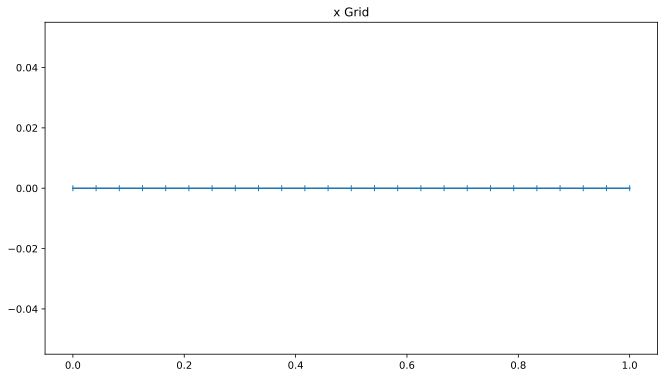

In [5]:
N = 24
x_mesh = UnitIntervalMesh(N)
x_coord = SpatialCoordinate(x_mesh)
V = FunctionSpace(x_mesh, "CG", 2)
W = FunctionSpace(x_mesh,"CG", 1)


# plot

x_plot = x_mesh.coordinates.dat.data
plt.plot(x_plot, [0 for i in range(len(x_plot))], marker = "|")
plt.title("x Grid")
plt.show()

## Physical Solve

In [6]:
epsilon = 0.01

u = TrialFunction(V)
v = TestFunction(V)
eps = Constant(epsilon)
x = Function(W).interpolate(x_coord[0])

# The rhs

u_known = cos(pi*x / 2) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps) )
u_prpr = (-pi**2)/4 * cos(pi*x / 2) - ( exp(-x/eps) ) / ( eps**2 * ( 1 - exp(-1/eps)) )
f = -eps**2 * u_prpr +  u_known


# The terms of the weak form

u_deriv = grad(u)
v_deriv = grad(v)

term1 = eps**2 * inner(u_deriv, v_deriv)
term2 = inner(u, v)

a = (term1 + term2) * dx

L = inner(f, v) * dx

# BC's

bcs = DirichletBC(V, known_solution(x, epsilon), "on_boundary")

# Solve the problem

u_sol = Function(V)
solve( a == L, u_sol, bcs)

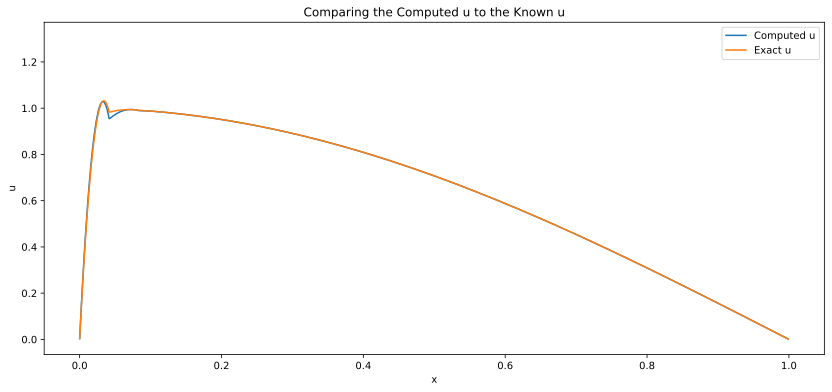

In [7]:
fig, axes = plt.subplots(figsize = (14,  6))

firedrake.pyplot.mpl.plot( u_sol, label = "Computed u", axes = axes)
firedrake.pyplot.mpl.plot(Function(V).interpolate(known_solution(x, epsilon)), label = "Exact u", axes = axes)
axes.set_title("Comparing the Computed u to the Known u")
axes.set_xlabel("x")
axes.set_ylabel("u")
axes.legend()
plt.show()

## Mesh Density Function (5.191 Inspired)

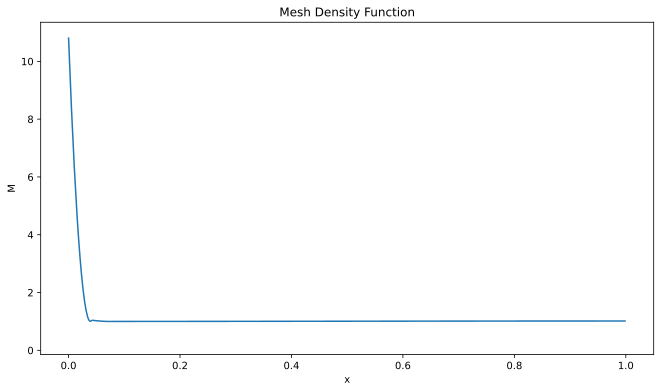

In [8]:
alpha_hat = Constant(1)

grad_x_sol = u_sol.dx(0)

alpha_a = assemble(alpha_hat**2 * ( ((u_sol)**2)* dx ))

alpha_b = assemble(( ( grad_x_sol * grad_x_sol )**(2/3) ) *  dx )**3

alpha = max(alpha_a , alpha_b)

M_a = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol) )**(-1/3)

M_b = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol ) )

M =  M_a * M_b


# Plot M

firedrake.pyplot.mpl.plot( Function(V).interpolate(M) )
plt.title("Mesh Density Function")
plt.xlabel("x")
plt.ylabel("M")
plt.show()

## Mesh Solve

In [9]:
# set solution and test function
new_xi = TrialFunction(W)
vm = TestFunction(W)

# v'
v_pr = vm.dx(0)
f = Function(W)

# dxi/dx

xi_pr = new_xi.dx(0)

# the lhs of the eqn
a = ( (1/M) * (xi_pr) * v_pr ) * dx
L = f*vm*dx

# bc's
bc0 = DirichletBC(W, Constant(0), 1)
bc1 = DirichletBC(W, Constant(1), 2)
bcs = [bc0, bc1]

# xi_sol

xi_sol = Function(W)

# solve
solve( a == L, xi_sol, bcs = bcs)


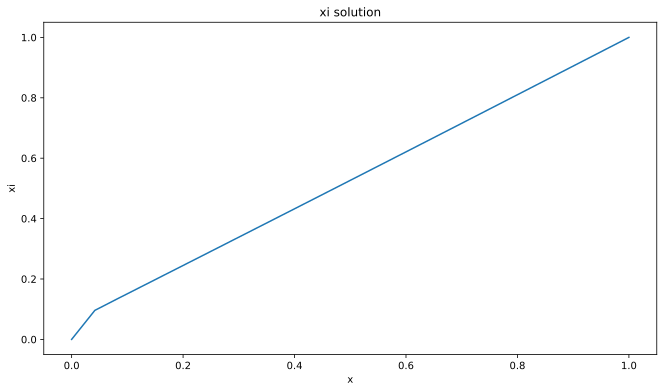

In [10]:
plot


plt.plot(x_mesh.coordinates.dat.data, xi_sol.dat.data)
plt.title("xi solution")
plt.xlabel('x')
plt.ylabel('xi')
plt.show()

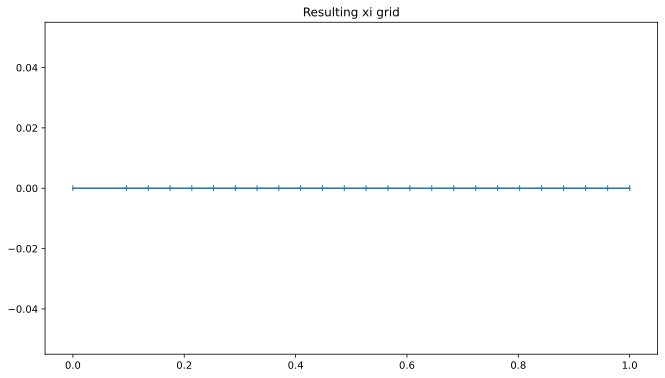

In [11]:
plt.plot(xi_sol.dat.data, [0 for i in range(N+1)], marker = "|")
plt.title('Resulting xi grid')
plt.show()

## Inverse Interpolation

In [12]:
# pull out my xi vals

xi = xi_sol.dat.data


# pull out my x vals

xvals = x.dat.data

# create the assumed uniform grid

y = np.linspace(0, 1, len(xvals))

# list for new x vals

phys_grid = []


for i in range(len(xi)):

  # print('i = ', i)
  # print("Finding interval for y[i] = ", y[i])

  # find the interval for y[i]

  for j in range(1, len(xi)):

    if ( (y[i] >= xi[j-1]) and (y[i] <= xi[j]) ):
      # print('found the interval : (', xi[j-1], ',', xi[j], ")")
      break

  # now j gives that interval!
  # compute the updates x


  m = (xi[j] - xi[j-1]) / ( xvals[j] - xvals[j-1] )

  x_new = xvals[j-1] + (y[i] - xi[j-1]) / m

  phys_grid.append(x_new)

  # print('finding the corresponding x value :', x_new)
  # print()
  # print()




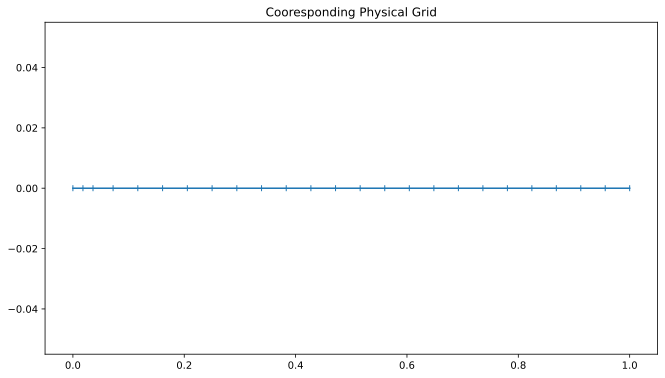

In [13]:
plt.plot(phys_grid, [0 for i in range(len(phys_grid))], marker = "|")
plt.title("Cooresponding Physical Grid")
plt.show()

# The MP - Iteration

## Create a Bakhvalov Mesh to Start Om

0.02
0.4889353954229168
0.0762171372385236
[-0.          0.00174023  0.00364643  0.00575364  0.0081093   0.01077993
  0.01386294  0.01750937  0.02197225  0.02772589  0.03583519  0.04969813
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[-0.          0.00174023  0.00364643  0.00575364  0.0081093   0.01077993
  0.01386294  0.01750937  0.02197225  0.02772589  0.03583519  0.04969813
  0.09621714  0.17153238  0.24684761  0.32216285  0.39747809  0.47279333
  0.54810857  0.62342381  0.69873905  0.77405428  0.84936952  0.92468476
  0.        ]



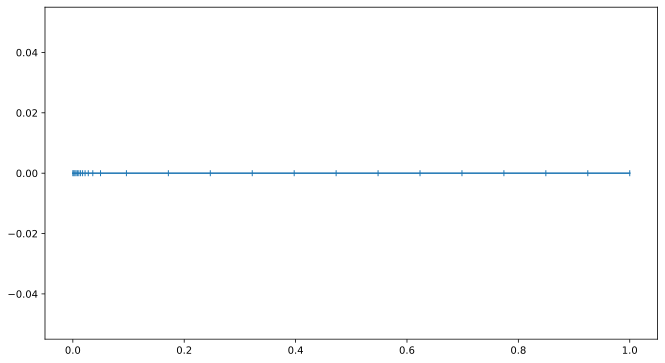

In [14]:
tau = 0
tauold = -11

sigma = 2
epsilon = 0.01
beta = 1
q = 0.5
layers = 1
N = 24

meps = sigma*epsilon/beta
print(meps)

while tau >= 0 and np.abs(tau - tauold ) > 1*10**(-10):
  tauold = tau
  #print(tau)

  chitau = meps*np.log(q/(q-tau))

  if (layers == 2):
    tau = q - meps*(1 - 2*tau)/(1-2*chitau)
  else:
    tau = q - meps*(1-tau)/(1-chitau)
chitau = meps*np.log(q/(q-tau))

print(tau)
print(chitau)


if chitau < 0.0:
  xB = np.linspace(0,1,N+1)

else:
  xB = np.zeros(N+1)
  if layers == 2:
    i = np.arange(0,N/2)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    print(xB)
    for p in range(k,int(N/2)):
      xB[p] = chitau + (1-2*chitau)/(1 - 2*tau) * ((i[p])/N - tau)
    xB[int(N/2)] = 0.5
    for p in range(int(N/2) + 1, N+1):
      xB[p] = 1 - xB[N-p]
    print(xB)
  else:
    i = np.arange(0,N)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    print(xB)
    for p in range(k,N):
      xB[p] = chitau + (1-chitau)/(1-tau) * ((i[p])/N-tau)
    print(xB)
    xB[N] = 1

yvals = np.linspace(0,1,len(xB))

print()
plt.plot(xB, [0 for i in range(len(xB))], marker = "|")
plt.show()

## The Iteration - Set up to Parameter Test the M That Uses u' '

If you want to use another M you must take the code outside of this triple loop over a,b,c

In [15]:
# the setup
N = 24
epsilon = 0.01
eps = Constant(epsilon)
MPIters = 50
deg = 2 # degree of FEM for physical solve
Bak = True # start on B mesh?
Bak_M = False # Use the B mesh M
HR_M = False # Use (5.191) Inspired M
Grad_M = False # Use a gradient based M designed to try and resemble the Bak_M but have solution dependence
Hess_M = False # M that used u''
second_deriv_M = True # M that uses u'' and is designed to resemble the B mesh generator

results = []


for a_c in [1/4, 1/2, 1, 2]:
  for b_c in [1/4, 1/2, 1, 2]:
    for c_c in [1/4, 1/2, 1, 2]:

      if Bak:
        x_mesh.coordinates.dat.data[:] = xB[:]
      else:
        x_mesh = UnitIntervalMesh(N)


      # Set the space
      x_coord = SpatialCoordinate(x_mesh)
      V = FunctionSpace(x_mesh, "CG", deg)
      W = FunctionSpace(x_mesh,"CG", 1)

      # Set the function
      x = Function(W).interpolate(x_coord[0])
      y = np.linspace(0, 1, len(x.dat.data)) # uniform y for interpolation

      x_list = [x.dat.data]


      # the iteration

      for i in range(MPIters):



        # THE PHYSICAL SOLVE



        u = TrialFunction(V)
        v = TestFunction(V)

        # The rhs

        u_known = cos(pi*x / 2) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps) )
        u_prpr = (-pi**2)/4 * cos(pi*x/ 2) - ( exp(-x/eps) ) / ( eps**2 * ( 1 - exp(-1/eps)) )
        f = -eps**2 * u_prpr +  u_known

        # The terms of the weak form

        u_deriv = grad(u)
        v_deriv = grad(v)

        term1 = eps**2 * inner(u_deriv, v_deriv)
        term2 = inner(u, v)

        a = (term1 + term2) * dx

        L = inner(f, v) * dx

        # BC's

        bcs = DirichletBC(V, known_solution(x, epsilon), "on_boundary")

        # Solve the problem

        u_sol = Function(V)
        solve( a == L, u_sol, bcs)




        # plot current x grid and the physical soln on this grid

        # fig, axes = plt.subplots(1, 2, figsize = (14, 6))
        # x_plot = x_mesh.coordinates.dat.data
        # axes[0].plot(x_plot, [0 for i in range(len(x_plot))], marker = "|")
        # axes[0].set_title("current x grid (linear winslow)")
        # firedrake.pyplot.mpl.plot(u_sol, label = "Computed u", axes = axes[1])
        # firedrake.pyplot.mpl.plot(Function(V).interpolate(known_solution(x, epsilon)), label = "Exact u", axes = axes[1])
        # plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", label = "x mesh", axes = axes[1])
        # axes[1].set_title("Comparing the Computed u to the Known u (on the x grid)")
        # axes[1].set_xlabel("x")
        # axes[1].set_ylabel("u")
        # axes[1].legend()
        # # if (i == 0 or i == (MPIters - 1)):
        # #   pdf_path = '/content/drive/My Drive/Summer_2024_Work/MeshForiequals' + str(i) + '.pdf'
        # #   plt.savefig(pdf_path)
        # plt.show()
        # print()
        # print()



        # THE MESH DENSITY FUNCTION

        if HR_M:
          alpha_hat = Constant(1)

          grad_x_sol = u_sol.dx(0)

          d = 1
          q = 2


          alpha_a = assemble(alpha_hat**2 * ( ((u_sol)**2)* dx ))

          alpha_b = assemble(( ( grad_x_sol * grad_x_sol )**(q/(d+q)) ) *  dx )**(2*(d+q)/q)

          if alpha == alpha_b:
            print('I am choosing alpha b')
          else:
            print('I am choosing alpha a')
          print()

          alpha = max(alpha_a , alpha_b)

          M_a = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol) )**(-1/(d+q))

          M_b = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol ) )

          M =  M_a * M_b


        if Bak_M:


          # Bakhvalov based M

          K0 = 0.4 # weight of points in layers
          K1 = 0.4
          rho = 0.99  # c >= rho^2
          sigma = 2.5  # sigma > order of FEM + 1

          Mt = K0 * rho * (1/eps) * ( exp( (-rho*x) / (sigma*eps) ) )

          M = 1 + Mt


        if Grad_M:

          rho = 0.99
          sigma = 2.5
          K0 = 0.4

          grad_x_sol = u_sol.dx(0)

          # alpha = 0.6325
          smile = rho/sigma
          alpha = K0 * rho *  eps**(smile-1) * ( 1 - exp(-1/eps))**smile
          a = smile
          b = 1
          c = 1

          M = c * (1 + alpha * abs( grad_x_sol )**a)**b



        if Hess_M:

          d = 1
          q = 2
          m = 0
          p = 2
          alpha_hat = 1

          u_pr = u_sol.dx(0)
          u_prpr = u_pr.dx(0)

          p1 = max((d*q) / (d + q*(2-m)) - 1, 0)
          p2 = (m*q - 1)/(d + q*(2-m)) + 1

          alpha_tild = 2 * 2**(p1)
          alpha_t1 = assemble(alpha_hat * ( ((u_sol)**2) * dx ))

          alpha = max(alpha_t1, alpha_tild)

          if alpha == alpha_tild:
            print("For the Hessian M I use the second alpha term (alpha tilda)")
          else:
            print("For the Hessian M I use the first alpha term")


          M = (1 + (1/alpha)*abs(u_prpr))**p2



        if second_deriv_M:


          u_pr = u_sol.dx(0)
          u_prpr = u_pr.dx(0)


          M = (1 + (a_c)*abs(u_prpr)**b_c)**c_c





        # THE MESH SOLVE



        # set solution and test function
        xi_trial = TrialFunction(W)
        vm = TestFunction(W)

        # v'
        v_pr = vm.dx(0)
        f = Function(W)

        # dxi/dx

        xi_pr = xi_trial.dx(0)

        # the lhs of the eqn
        a = ( (1/M) * (xi_pr) * v_pr ) * dx
        L = f*vm*dx

        # bc's
        bc0 = DirichletBC(W, Constant(0), 1)
        bc1 = DirichletBC(W, Constant(1), 2)
        bcs = [bc0, bc1]

        # xi_sol

        xi_sol = Function(W)

        # solve
        solve( a == L, xi_sol, bcs = bcs)



        # THE INVERSE INTERPOLATION




        # pull out my xi vals

        xi = xi_sol.dat.data

        # pull out my x vals

        xvals = x_mesh.coordinates.dat.data

        # list for new x vals

        phys_grid = []


        for k in range(len(xi)):

          # find the interval for y[i]

          for j in range(1, len(xi)):

            if ( (y[k] >= xi[j-1]) and (y[k] <= xi[j]) ):
              break

          # now j gives that interval!
          # compute the updated x


          m = (xi[j] - xi[j-1]) / ( xvals[j] - xvals[j-1] )

          x_new = xvals[j-1] + (y[k] - xi[j-1]) / m

          phys_grid.append(x_new)


        # numpy l2

        # print('Norm of meshes :', np.linalg.norm(phys_grid - xvals))
        # print()



        # save the new x

        x_list.append(phys_grid)



        # UPDATE x



        x_mesh.coordinates.dat.data[:] = phys_grid[:]
        x_coord = SpatialCoordinate(x_mesh)
        V = FunctionSpace(x_mesh, "CG", deg)
        W = FunctionSpace(x_mesh,"CG", 1)
        x = Function(W).interpolate(x_coord[0])




      fig, axes = plt.subplots(1, 2, figsize = (14, 6))
      x_plot = x_mesh.coordinates.dat.data
      axes[0].plot(x_plot, [0 for i in range(len(x_plot))], marker = "|")
      axes[0].set_title("current x grid (linear winslow)")
      firedrake.pyplot.mpl.plot(u_sol, label = "Computed u", axes = axes[1])
      firedrake.pyplot.mpl.plot(Function(V).interpolate(known_solution(x, epsilon)), label = "Exact u", axes = axes[1])
      plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", label = "x mesh", axes = axes[1])
      axes[1].set_title("Comparing the Computed u to the Known u (on the x grid)")
      axes[1].set_xlabel("x")
      axes[1].set_ylabel("u")
      axes[1].legend()
      # if (i == 0 or i == (MPIters - 1)):
      #   pdf_path = '/content/drive/My Drive/Summer_2024_Work/MeshForiequals' + str(i) + '.pdf'
      #   plt.savefig(pdf_path)
      plt.tight_layout()
      plt.close(fig)
      results.append([a_c, b_c, c_c, fig])






In [16]:
# plot the results

for i in range(len(results)):
  print('The results for : ', end = "")
  print("a = ", results[i][0], end = " ")
  print("b = ", results[i][1], end = " ")
  print(" c = ", results[i][2])
  print("-"*150)
  print()
  print()
  display(results[i][3])
  print()
  print()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# indices = np.arange(-10, 0, 1)

# for j in indices:

#   plt.plot(x_list[j], [0 for i in range(len(x_list[j]))], marker = "|", label = "Mesh Number " + str(j+50))

# plt.legend()
# plt.title("The Last 10 x Grids for eps = 0.01, p = 1/4, d = 2")
# pdf_path = '/content/drive/My Drive/Summer_2024_Work/last10meshes.pdf'
# plt.savefig(pdf_path)

